# Imports

In [23]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Multi_Label_Text_Classification')
base_dir = 'gdrive/My Drive/Colab Notebooks/Multi_Label_Text_Classification/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip3 install --quiet "tensorflow>=1.7"
!pip3 install --quiet tensorflow-hub

In [25]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import glob
import functools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
#from skmultilearn.problem_transform import LabelPowerset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import scipy

import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

from helper_functions import *
import tensorflow as tf
import tensorflow_hub as hub

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Few relevant functions

In [0]:
def plot_similarity(labels, features, rotation):
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    corr = np.inner(features, features)
    fig = plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=unique_labels,
        yticklabels=unique_labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(unique_labels, rotation=rotation)
    ticks = np.linspace(len(features)/len(unique_labels)/2, len(features)-len(features)/len(unique_labels)/2, len(unique_labels), dtype=np.int)
    g.set_xticks(ticks)
    g.set_yticks(ticks)
    g.set_title("Semantic Textual Similarity for: {}".format(unique_labels))


def run_and_plot(messages_, labels):
    similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
    similarity_message_encodings = embed(similarity_input_placeholder)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())  
        message_embeddings_ = session.run(similarity_message_encodings, feed_dict={similarity_input_placeholder: messages_})
        plot_similarity(labels, message_embeddings_, 90)

In [0]:
def get_2d_representation(words_list, labels):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        description_embeddings  =  session.run(embed(words_list)) #Generates the sentence embeddings
        
        model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
        # Apply the fit_transform method of model to grains: pca_features
        pca_features = model.fit_transform(description_embeddings) # Transforms embeddings to vectors of size 2
        # Assign 0th column of pca_features: xs
        xs = pca_features[:,0] #The first component of PCA
        # Assign 1st column of pca_features: ys
        ys = pca_features[:,1] #Second component of PCA
        
        #Next, we'll plot these results
        tmp = {}
        label_idx = [tmp.setdefault(name, len(tmp)) for name in labels]
        unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
        df = pd.DataFrame({'x':xs, 'y': ys, 'label':label_idx})
        colors = ['r', 'b', 'g', 'm', 'k']
        
        fig, ax = plt.subplots(figsize=(10,10)) 
        for idx in range(len(set(labels))):
          ax.scatter(df[df['label']==idx].x, df[df['label']==idx].y, c=colors[idx], label=unique_labels[idx])
        
        ax.set(title='PCA Representation for Genres: {}'.format(unique_labels))
        ax.legend()

In [0]:
def movie_genre_heatmap(features, labels):
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    corr = np.inner(features, features)
    fig = plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=unique_labels,
        yticklabels=unique_labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(unique_labels, rotation=90)
    ticks = np.linspace(len(features)/len(unique_labels)/2, len(features)-len(features)/len(unique_labels)/2, len(unique_labels), dtype=np.int)
    g.set_xticks(ticks)
    g.set_yticks(ticks)
    g.set_title("Semantic Textual Similarity for: {}".format(unique_labels))


In [0]:
def movie_genre_scatter_plot(movie_plot_vectors, labels):
    model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
    # Apply the fit_transform method of model to grains: pca_features
    pca_features = model.fit_transform(movie_plot_vectors) # Transforms embeddings to vectors of size 2
    # Assign 0th column of pca_features: xs
    xs = pca_features[:,0] #The first component of PCA
    # Assign 1st column of pca_features: ys
    ys = pca_features[:,1] #Second component of PCA

    #Next, we'll plot these results
    tmp = {}
    label_idx = [tmp.setdefault(name, len(tmp)) for name in labels]
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    df = pd.DataFrame({'x':xs, 'y': ys, 'label':label_idx})
    colors = ['r', 'b', 'g', 'm', 'k']

    fig, ax = plt.subplots(figsize=(10,10)) 
    for idx in range(len(set(labels))):
      ax.scatter(df[df['label']==idx].x, df[df['label']==idx].y, c=colors[idx], label=unique_labels[idx])

    ax.set(title='PCA Representation for Genres: {}'.format(unique_labels))
    ax.legend()

In [0]:
def embed_movie_plots(data_text, train_or_test='train'):
    chunk_size = 1000
    num_chunks = math.ceil(data_text.shape[0]/chunk_size)
    for idx in range(num_chunks):
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            data_vector  =  session.run(embed(list(data_text.iloc[idx*chunk_size:(idx+1)*chunk_size]))) #Generates the sentence embeddings
            np.save(base_dir+'Data/preprocessed/embed_vector/movies_genres_'+train_or_test+'_vector_'+str(idx)+'.npy', data_vector)

# MODELING

**Loading the input**

In [0]:
#mydata_train = pd.read_csv('./../Data/preprocessed/movies_genres_train_preprocessed.csv')
#mydata_test = pd.read_csv('./../Data/preprocessed/movies_genres_test_preprocessed.csv')
#mydata = pd.read_csv('../Data/movies_genres.csv', delimiter='\t')

mydata_train = pd.read_csv(base_dir+'Data/preprocessed/movies_genres_train_preprocessed.csv')
mydata_test = pd.read_csv(base_dir+'Data/preprocessed/movies_genres_test_preprocessed.csv')
mydata = pd.read_csv(base_dir+'Data/movies_genres.csv', delimiter='\t')

In [0]:
train_X, train_y = mydata_train['plot'], mydata_train.drop(['title', 'plot', 'plot_lang'], axis=1)
test_X, test_y = mydata_test['plot'], mydata_test.drop(['title', 'plot', 'plot_lang'], axis=1)

category_columns = train_y.columns

In [33]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

Instructions for updating:
Colocations handled automatically by placer.


W0421 16:58:53.410064 140549948516224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


## Obtain Plot Embedding

In [0]:
# embed_movie_plots(train_X, train_or_test='train')
# embed_movie_plots(test_X, train_or_test='test')

train_files = glob.glob(base_dir+"Data/preprocessed/embed_vector/*train*.npy")
train_vector_set = []
for file in train_files:
  train_vector_set.append(np.load(file))
train_vector = np.concatenate(train_vector_set)

test_files = glob.glob(base_dir+"Data/preprocessed/embed_vector/*test*.npy")
test_vector_set = []
for file in test_files:
    test_vector_set.append(np.load(file))
test_vector = np.concatenate(test_vector_set)

## Visualizing Plot Similarities
Let us pick plots from few genres and see how this universal sentence encoder embeds them into vectors.  
**Heatmap Visualization** 
* We pick the first 50 plots from 3 genres (150 plots in all) 
* Using the embedded vectors for these we plot the heatmap
* Plots from similar genre are expected to show higher correlation

**PCA 2D Representation Visualization**
* We pick the first 50 plots from 3 genres (150 plots in all) 
* We obtain the 2 largest variance components using PCA for these 150 vectors and project them along these components
* Plots from similar genre are expected to be closeby and form a cluster

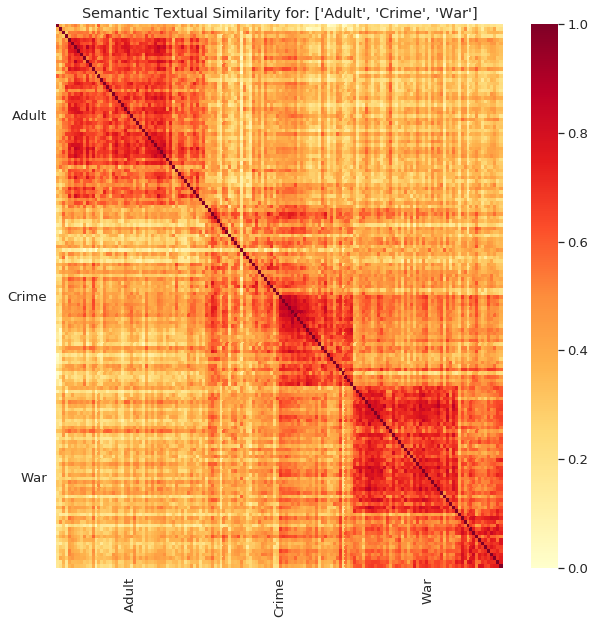

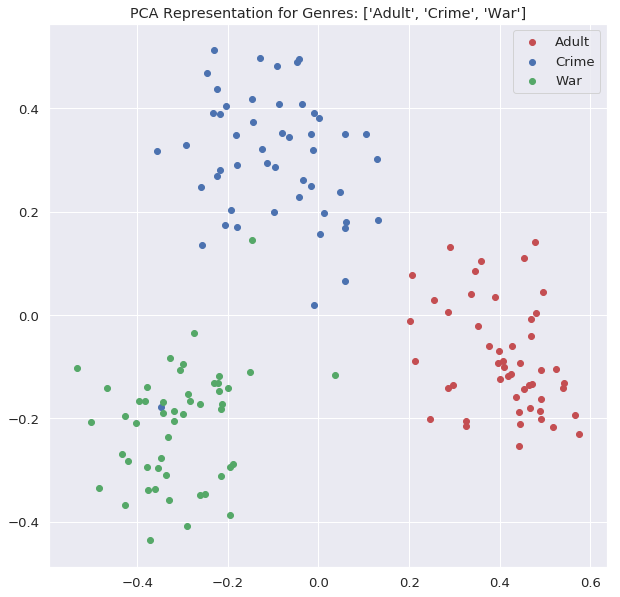

In [35]:
genre_list = ['Adult', 'Crime', 'War']
plot_inp_set = []
genre_inp = []
for genre in genre_list:
    plot_inp_set.append(train_vector[train_y[genre]==1][:50])
    genre_inp+=[genre]*50

plot_inp=np.concatenate(plot_inp_set)
movie_genre_heatmap(plot_inp, genre_inp) 
movie_genre_scatter_plot(plot_inp, genre_inp)

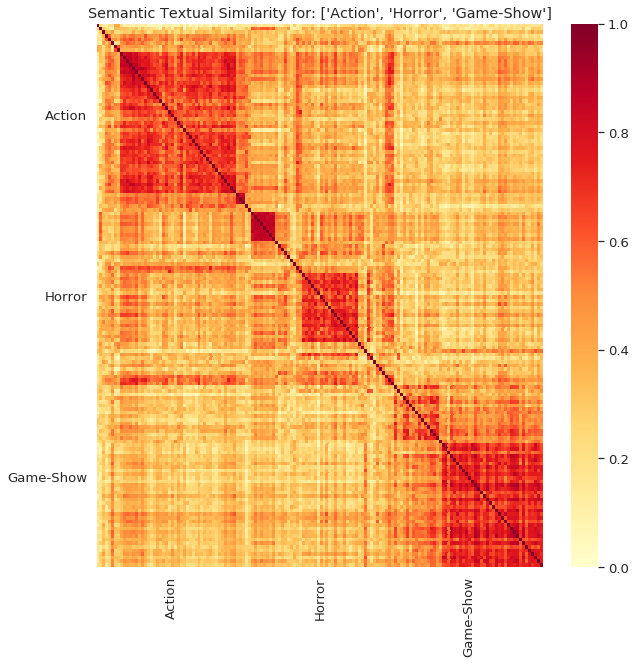

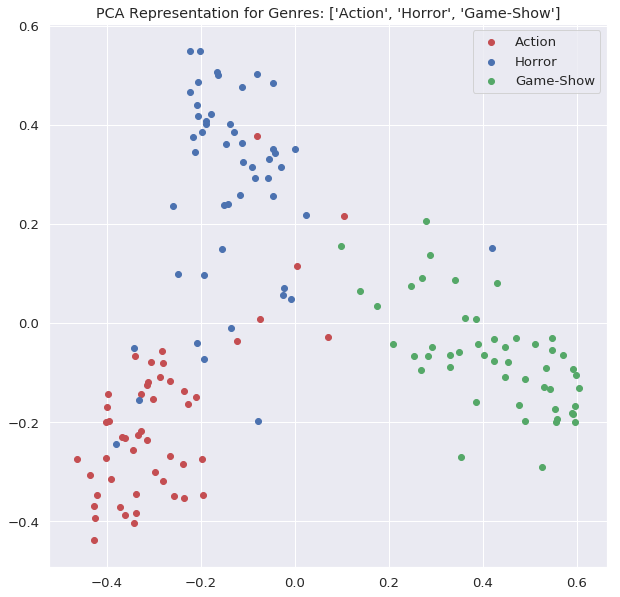

In [36]:
genre_list = [ 'Action', 'Horror', 'Game-Show']
plot_inp_set = []
genre_inp = []
for genre in genre_list:
    plot_inp_set.append(train_vector[train_y[genre]==1][:50])
    genre_inp+=[genre]*50

plot_inp=np.concatenate(plot_inp_set)
movie_genre_heatmap(plot_inp, genre_inp) 
movie_genre_scatter_plot(plot_inp, genre_inp)

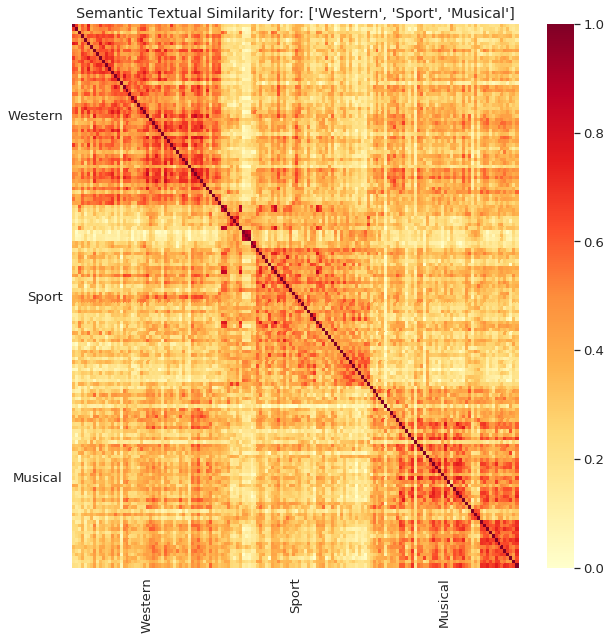

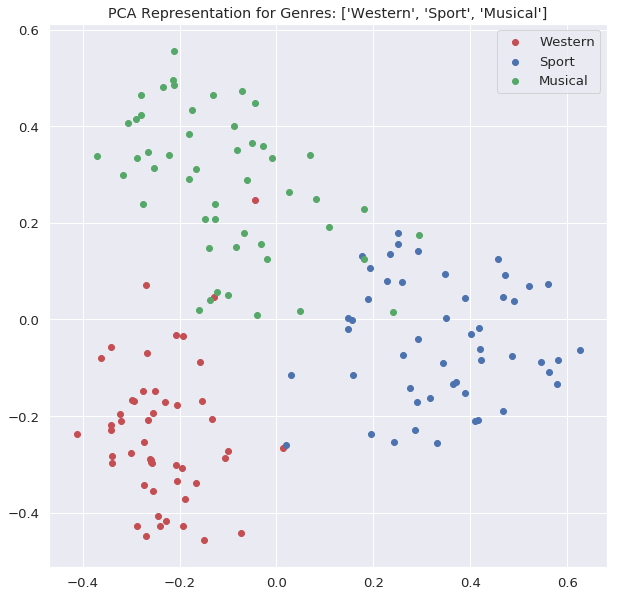

In [37]:
genre_list = ['Western', 'Sport', 'Musical']
plot_inp_set = []
genre_inp = []
for genre in genre_list:
    plot_inp_set.append(train_vector[train_y[genre]==1][:50])
    genre_inp+=[genre]*50

plot_inp=np.concatenate(plot_inp_set)
movie_genre_heatmap(plot_inp, genre_inp) 
movie_genre_scatter_plot(plot_inp, genre_inp)

## Prediction via Cosine Similarity

From the above plots, we noticed that similar genre movies have similar embedding vectors. In this method, we aim to predict the genres of the movie using a cosine similarity function as described in the below
* Obtain the mean vector representation for each of the unique label combinations. 
  * There are 1505 unique genre combinations
  * For each of these 1505 combinations, get a representative embedding vector = mean of all the vectors with similar genre combination
* For each movie plot, get a cosine similarity with each of the 1505 genre combinations
* Assign the genre combination which yields the maximum cosine similarity


Disadvantage
* Very high prediction time
  * First, we will have to load the Universal Sentence Encoder
  * Encode the plot into a 512 vector
  * Get cosine similarity of the vector with 1505 genre combinations
* High memory too
  * We will have to store 1505X512 sized Look-up Table (LUT) 

In [0]:
def cosine(s1, s2):
  """Take two pd.Series objects and return their cosine similarity."""
  return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

def max_cosine(vector, label_embedding):
  '''Function returns the label_embedding index with maximum cosine 
  similarity with the input vector '''
  max_idx, max_cosine_sim = -1, float('-inf')
  if vector['index']%1000==0:
    print('Processing plot idx {0}'.format(vector['index']))
  for idx in range(label_embedding.shape[0]):
    curr_sim = cosine(vector[1:], label_embedding.iloc[idx,:])
    (max_idx, max_cosine_sim) = (idx, curr_sim) if curr_sim>max_cosine_sim else (max_idx, max_cosine_sim)
  return pd.Series([max_idx, max_cosine_sim])

def max_cosine_unit_test(vector, label_embedding):
  '''Used for debugging individual vectors. Returns the entire cosine
  similarity array'''
  cosine_list = []
  for idx in range(label_embedding.shape[0]):
    cosine_list.append(cosine(vector, label_embedding.iloc[idx,:]))
  return cosine_list

Now let us prepare the required labels to embedding vector LUT

In [0]:
# Creating a LUT for the 1505 labels
train_y_labels= train_y.groupby(list(category_columns)).ngroup()
y_labels_lut = train_y.copy(deep=True) 
y_labels_lut['Labels'] = train_y_labels
y_labels_lut = y_labels_lut.drop_duplicates()
y_labels_lut = y_labels_lut.reset_index(drop=True).set_index('Labels').sort_index()

# Getting the embedding vectors for each of the unique 1505 labels
train_vector_df = pd.DataFrame(train_vector)
train_vector_df['Labels'] = train_y_labels
label_embedding = train_vector_df.groupby('Labels').mean()

# Converting the vectors into dataframe so that we can use the apply method
test_vector_df = pd.DataFrame(test_vector)
test_vector_df = test_vector_df.reset_index()

Run cosine similarity make predictions

In [48]:
%%time
y_pred_df = test_vector_df.apply(max_cosine, label_embedding=label_embedding, axis=1)

Processing plot idx 0.0
Processing plot idx 0.0
Processing plot idx 1000.0
Processing plot idx 2000.0
Processing plot idx 3000.0
Processing plot idx 4000.0
Processing plot idx 5000.0
Processing plot idx 6000.0
Processing plot idx 7000.0
Processing plot idx 8000.0
Processing plot idx 9000.0
Processing plot idx 10000.0
Processing plot idx 11000.0
Processing plot idx 12000.0
Processing plot idx 13000.0
Processing plot idx 14000.0
Processing plot idx 15000.0
Processing plot idx 16000.0
Processing plot idx 17000.0
Processing plot idx 18000.0
Processing plot idx 19000.0
Processing plot idx 20000.0
Processing plot idx 21000.0
Processing plot idx 22000.0
CPU times: user 8h 44min 10s, sys: 1min 28s, total: 8h 45min 39s
Wall time: 8h 51min


In [49]:
predictions = pd.merge(y_pred_df, y_labels_lut, how='left', left_on=0, right_on='Labels')[category_columns]
accuracy(test_y, predictions)

,Precision,Recall,F1-Score,Support
Action,0.58,0.68,0.63,4321.0
Adult,0.13,0.27,0.18,11.0
Adventure,0.50,0.66,0.57,3496.0
Animation,0.69,0.71,0.70,3333.0
Biography,0.18,0.47,0.26,354.0
Comedy,0.61,0.64,0.62,7320.0
Crime,0.65,0.67,0.66,4453.0
Documentary,0.47,0.53,0.50,1863.0
Drama,0.75,0.73,0.74,11067.0
Family,0.53,0.63,0.57,4173.0


**Observations**  

